# 22  Regression discontinuity designs

**2024/5/14 闫晴宜、林海欣  
分工情况：各自完成代码和讨论问题，整合展示**

自1999年之后，越来越多的研究采用RDD的方法进行因果推断（Cunningham (2021) ）<br>
由于RDD的假设相对于其他的理论验证方法更加温和，所以结果也更加可信（Lee and Lemieux (2010, p. 282)）<br>
<br>
本文的目标是两个问题：
1. 如何在自己的文章中使用RDD
2. 如何理解文献中的RDD

## 22.1 Sharp RDD（精确断点回归）
基本思想：一个原因变量D完全依赖于一个参考变量X(running/assignment/forcing variable)，参考变量本身也可能影响结果，如果有影响，参考变量对Y的影响是连续的，所有其他影响结果的变量影响都是连续的，则结果变量在断点处的跳跃，可以归因为原因变量D的影响。<br>
<br>
在研究时，设置一个原因变量D，在断点前后分别取值0和1
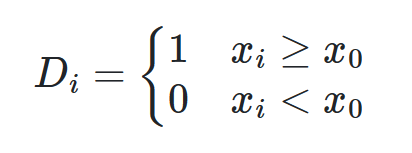

例子：Thistlethwaite and Campbell, 1960：<br>
研究某次考试成绩11分及以上和11分以下 对奖学金发放是否有影响

#### RDD的基本假设：<br>
1. f(·)是连续的<br>
假设的意义：推导出RDD系数<br>
在精确断点回归中，可以将断点两侧看作两条直线，并得到断点左右两侧的期望值<br>
当任意小的正数Δ无线趋近于0时，可以认为断点两侧的期望值之差为ρ<br>

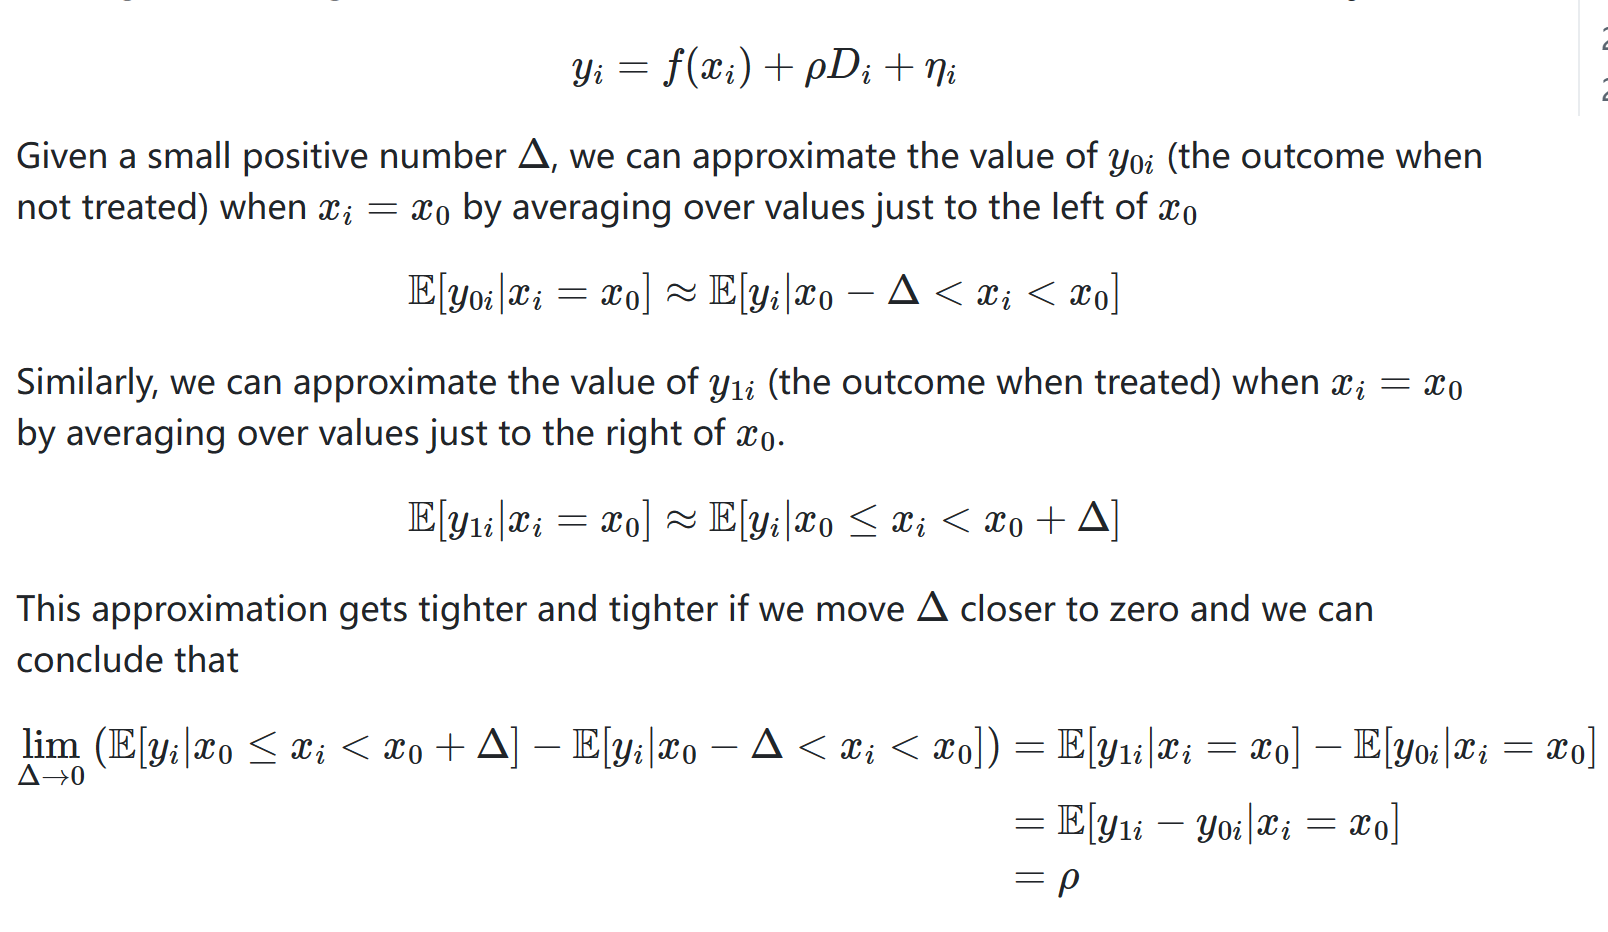

2. 局部随机化假设
假设在断点附近是近似于完全随机化实验<br>
即落入断点左侧或右侧完全是随机的<br>
在实践中，这个隐含的假设可能并不成立，下文会对讨论如何对此假设的偏差进行检测<br><br>

Tips：<br>
在实践中，既要使任意小正数Δ无限趋近于0，又要有足够的样本用以分析，满足计算ρ的两个条件期望，因此在研究的时候需要考虑如何平衡两点

### 22.1.1 Use of polynomial regressions

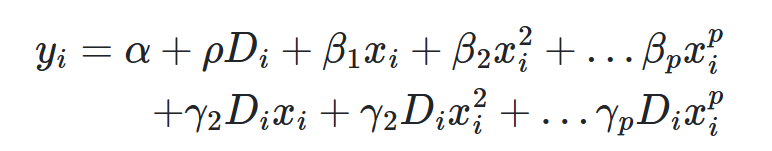

Gelman and Imbens (2019)：
存在缺陷：
1. 噪音
2. 对多项式的幂非常敏感
3. 置信区间覆盖度：excessive rejection of true null hypotheses

建议研究者选择局部线性或二次多项式或其他平滑函数估计<br>
提供了rdrobust package用以分析

### 22.1.2 Manipulation of the running variable

尽管RDD的假设都比较温和，在实践中仍然可能不成立<br>
- 对参考变量（running variable）的操纵，可能会导致处置效应结果偏差<br>
e.g. Hoekstra (2009) 研究了SAT成绩与未来收入的关系<br>
如果学生们意识到了SAT成绩和收入的关系，且存在一个阈值，那么在第一次考试中没有得到理想成绩的学生会重新进行考试，导致阈值左侧和右侧学生对于考试所付出的精力和时间显著不同，最后导致RDD的研究可信度下降。<br>

- 存在验证数据是否存在这种效应的方法 (Listokin, 2008; McCrary, 2008）

## 22.2 Fuzzy RDD（模糊断点回归）


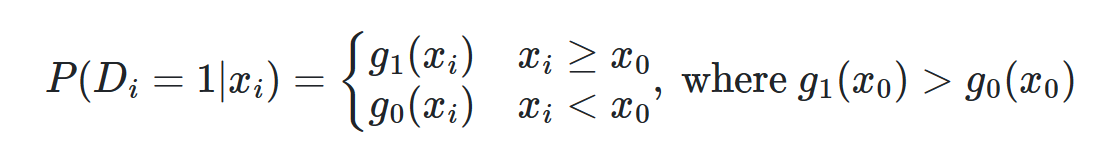

Fuzzy RDD是在Sharp RDD基础上，工具变量法IV的运用<br>

- 如果在断点处接受实验的概率从0变为1，则称为清晰断点回归
- 如果在断点处接受实验的概率从a变为b（0<a<b<1），那么这种就称为模糊断点回归。

模糊性断点考虑的问题是多纳入了其他的研究变量<br>
由于在模糊断点中，一些个体如同高考录取一样会选择不接受实验或提前接受实验，那么内生性问题就会出现，政策的实施不再是随机自然实验。<br>
为了解决内生问题，可以运用工具变量法，将变量是否超过阈值设置为原因变量D，作为是否接受实验的工具变量，运用2SLS方法最终去评估政策实施效果。<br>

## 22.3 Other issues

1. 断点值和实际问题相关<br>
e.g.,在指定 7500 万美元的公众持股量作为适用《萨班斯-奥克斯利法案》(SOX) 要求的门槛时，SEC 可能会推断，此时 SOX 的收益大约等于遵守该法案的成本它。如果属实，虽然该法律对持股量远高于阈值的公司股东有实质性好处，但预计影响大约为零。<br>
2. 估计中使用的窗口宽度（即实际上根据观测值与截止点的距离给予观测值多少权重）<br>
Gow et al. (2016) 鼓励使用 RDD 的研究人员采用现有的方法来估计最佳窗口宽度以及由此产生的效果估计（Imbens, Kalyanaraman，2012）。<br>
rdrobust package提供了各种估计最佳窗口宽度的方法<br>

## 22.4 Sarbanes-Oxley Act
+ SOX法案第404节要求上市公司在年度报告中包含对财务报告内部控制有效性的评估，并需要外部审计师对管理层评估发表意见。  
+ 这一规定增加了公司的合规成本的，尤其是对小公司而言。  
+ 只有2002-2004年间任意一年的公开流通股价值超过7500万美元的大公司需要在2004年11月15日或之后的财年结束时遵守SOX 404。  
+ 小公司直到2007年财年才需要提交管理报告。
+ Iliev(2010)的研究利用公开流通股在7500万美元左右的不连续性，分析了SOX 404对审计费用和盈余管理的影响。

In [1]:
import sqlite3
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from rdrobust import rdrobust, rdplot

### 数据导入

In [2]:
iliev_2010 = pd.read_csv(
    "iliev_2010.csv", 
    index_col=0,
    dtype={"gvkey": str},
    parse_dates=['fdate', 'pfdate'])
iliev_2010['pfyear'] = iliev_2010['pfyear'].astype(int)

bloomfield_2021 = pd.read_csv(
    "bloomfield_2021.csv", 
    index_col=0,
    dtype={"permco": str},)
bloomfield_2021['fyear'] = bloomfield_2021['fyear'].astype(int)

In [3]:
rdd = sqlite3.connect(database='rdd.sqlite')
rdd.execute('SELECT name FROM sqlite_master').fetchall()

[('ccmxpf_lnkhist',), ('funda',), ('factors_daily',), ('dsf',)]

In [4]:
ccmxpf_lnkhist = pd.read_sql_query(
    sql="SELECT * FROM ccmxpf_lnkhist",
    con=rdd, 
    dtype={"lpermco": str, "gvkey": str})

funda = pd.read_sql_query(
    sql="SELECT * FROM funda",
    con=rdd, 
    dtype={"gvkey": str},
    parse_dates={'datadate'})

factors_daily = pd.read_sql_query(
    sql="SELECT * FROM factors_daily",
    con=rdd, 
    parse_dates={'date'})

dsf = pd.read_sql_query(
    sql="SELECT * FROM dsf",
    con=rdd, 
    parse_dates={'date'})

In [5]:
iliev_2010.head(5)

,gvkey,fyear,fdate,pfdate,pfyear,publicfloat,mr,af,cik
1,028712,2001,2001-12-31,2002-03-21,2002,21.523,False,False,908598
2,028712,2002,2002-12-31,2002-06-28,2002,11.460,False,False,908598
3,028712,2003,2003-12-31,2003-06-30,2003,13.931,False,False,908598
4,028712,2004,2004-12-31,2004-06-30,2004,68.161,False,False,908598
5,028712,2005,2005-12-31,2005-06-30,2005,26.437,False,False,908598


**【iliev_2010数据】**  
上市公司公开流通股价值数据，数据来自Iliev (2010)的研究    

**【字段说明】**  
gvkey：Compustat公司标识符  
fyear：财政年度  
fdate：财政年度结束日期  
pfdate：公开流通股价值日期  
pfyear：公开流通股价值年份  
publicfloat：公开流通股价值（单位：百万美元）  
mr：是否提交管理报告  
af：是否为需要加速提交管理报告的公司  
cik：SEC公司标识符

In [6]:
bloomfield_2021.head(5)

,fyear,permco
1,2001,283
2,2002,283
3,2003,283
4,2004,283
5,2005,283


**【bloomfield_2021数据】**  
Bloomfield (2021)中RDD研究的公司-年份对应数据

**【字段说明】**  
fyear：财政年度  
permco：CRSP公司标识符

In [7]:
ccmxpf_lnkhist.head(5)

,linktype,linkprim,lpermco,gvkey
0,NU,C,nan,001000
1,NU,P,nan,001000
2,LU,P,23369.0,001000
3,NU,C,nan,001001
4,LU,P,6398.0,001001


**【ccmxpf_lnkhist数据】**  
Compustat和CRSP链接数据

**【字段说明】**  
gvkey：Compustat数据库的公司代码，是链接Compustat和CRSP数据的关键字段之一。  
linkprim：链接是否为主要链接。因为一个公司可能有多只股票（例如，普通股和优先股），所以这个字段指明哪些链接指向公司的主要股票。"P"表示主要普通股，"C"表示合并（合并财务报表）。  
linktype：链接类型，即Compustat数据和CRSP数据之间如何关联。不同的类型可能代表不同的链接质量或用途，例如一些链接可能是基于特定时间段内的一致性检验。  
lpermco：等同于permco，CRSP的公司代码。    

In [8]:
funda.head(5)

,indfmt,datafmt,consol,popsrc,auopic,gvkey,fyear,datadate
0,INDL,STD,C,D,None,001000,1961.0,1961-12-31
1,INDL,STD,C,D,None,001000,1962.0,1962-12-31
2,INDL,STD,C,D,None,001000,1963.0,1963-12-31
3,INDL,STD,C,D,None,001000,1964.0,1964-12-31
4,INDL,STD,C,D,None,001000,1965.0,1965-12-31


**【funda数据】**  
公司年度报告数据  

**【字段说明】**  
indfmt：行业格式，如“INDL”代表工业标准格式  
datafmt：数据格式，如“STD”代表标准格式  
consol：合并标志，表示财务数据基于单独公司还是集团合并，“C”代表合并数据  
popsrc：数据来源，如“D”通常表示直接从公司获取的数据    
auopic：审计师对公司财务报告内部控制的有效性的意见，0表示“无审计报告”，1表示“有效（无重大缺陷）”，2表示“不利（存在重大缺陷）”，3表示“免责声明（无法表达意见）”，4表示“延迟提交”  
gvkey：Compustat数据库的公司标识符  
datadate：报告的财务日期，通常是财务年度的最后一天  
fyear：报告的财务年度

In [9]:
factors_daily.head(5)

,date,rf,mktrf
0,1926-07-01,0.00009,0.0010
1,1926-07-02,0.00009,0.0045
2,1926-07-06,0.00009,0.0017
3,1926-07-07,0.00009,0.0009
4,1926-07-08,0.00009,0.0021


**【factors_daily数据】**  
股票市场日度收益率数据

**【字段说明】**  
date：日期  
rf：无风险收益率（一月期国债利率）  
mktrf：市场超额收益率  

In [10]:
dsf.head(5)

,permco,date,ret
0,7953,2000-01-03,0.007353
1,7953,2000-01-04,-0.014599
2,7953,2000-01-05,0.014815
3,7953,2000-01-06,-0.007299
4,7953,2000-01-07,-0.007353


**【dsf数据】**  
个股日度收益率数据

**【字段说明】**  
permco：CRSP股票代码  
date：日期  
ret：个股收益率

### SOX 404筛选标准

根据SOX 404的accelerated filers要求筛选需要提前报告内控有效性的公司财报：  
（1）2002（2002年11月-2003年10月)，2003（2003年11月-2004年10月)，2004（2004年11月-2005年10月)期间任意一年的流通股价值在75百万美元（含）以上。  
（2）在2004-11-15以后发布。

In [11]:
# 筛选accelerated filer
mr_req_df = (iliev_2010
             .dropna(subset=['fdate'])
             .query("fdate >= '2002-11-01' and fdate <= '2005-10-31'"))
mr_req_df['max_float'] = (mr_req_df
                          .groupby(['gvkey', 'fdate'])['publicfloat']
                          .transform('max'))
mr_req_df = mr_req_df.query("fdate >= '2004-11-15'").assign(mr_required=lambda x: x['max_float'] >= 75)
mr_req_df

,gvkey,fyear,fdate,pfdate,pfyear,publicfloat,mr,af,cik,max_float,mr_required
4,028712,2004,2004-12-31,2004-06-30,2004,68.161000,False,False,908598,68.161000,False
10,013864,2005,2005-03-31,2004-09-30,2004,9.041667,False,False,819527,9.041667,False
16,007696,2005,2005-03-31,2004-09-26,2004,32.148000,False,False,69733,32.148000,False
22,025138,2005,2005-07-31,2005-01-31,2005,43.956217,False,False,884144,43.956217,False
27,020202,2004,2004-12-31,2004-06-30,2004,17.417671,False,False,858452,17.417671,False
...,...,...,...,...,...,...,...,...,...,...,...
7188,024350,2005,2005-03-26,2005-05-27,2005,315.970000,True,True,876427,315.970000,True
7193,013407,2004,2004-12-31,2004-06-30,2004,253.499563,True,True,812708,253.499563,True
7198,062745,2004,2004-12-31,2005-03-28,2005,557.486684,True,True,1009829,557.486684,True
7205,010044,2005,2005-09-30,2005-03-31,2005,269.233796,True,True,771790,269.233796,True


符合SOX 404筛选标准，但没有且不需要提前报告内控有效性的财务报告：

In [12]:
(mr_req_df[(mr_req_df['mr_required'])
           & (~mr_req_df['mr']) 
           & (~mr_req_df['af'])][['cik', 'fdate', 'pfdate', 'publicfloat']]
 .sort_values('publicfloat')
 .tail(6))

,cik,fdate,pfdate,publicfloat
2727,1003472,2004-12-31,2005-03-09,141.985280
3003,943861,2004-12-31,2005-03-24,168.534600
1395,906780,2004-12-31,2005-03-01,171.662126
100,1085869,2004-12-31,2005-02-28,172.091616
3946,29834,2004-12-31,2005-03-16,184.901979
6228,1028205,2005-06-30,2005-08-15,279.101648


### 22.4.1 Bloomfield ( 2021 )
+ Bloomfield（2021）预测，SOX 404减少报告灵活性会降低管理者隐藏糟糕业绩的能力，从而降低风险不对称性（公司回报与市场负回报的相关性大于与市场正回报的相关性）。  
+ Bloomfield（2021）遵循Iliev（2010）的RDD方法，并使用DiD估计财报灵活性对风险不对称性的影响。
+ Bloomfield（2021）将公司2002年（在75百万美元的门槛公告之前）的公开流通股价值作为工具变量，用以判断公司在2004年底是否会受到SOX 404影响。  
    RDD利用75百万美元的公开流通股阈值处理组公司对照组公司。使用RDD需要满足断点附近的公司被随机分配到处理组和对照组的假设，从而使得处理组和对照组之间的差异可以可信地归因于处理效应，而非其他干扰因素。然而，研究表明这种随机分配的假设可能被违反，因为公司可能通过管理公开流通股的数量来有意选择成为非加速报告者，表现为SOX 404发布后，公开流通股在75阈值附近，低于75的公司数量激增，而高于75的公司数量骤降。  
    为了应对这一问题，研究中使用了2002年的公开流通股数据作为工具变量，因为那时SOX 404仍未发布，公司尚无动机操控公开流通股数额。
+ 鉴于Bloomfield（2021）中引入公司规模、年限等控制变量并没有改变结论，本研究省略了这些控制变量。

将当年内不同日期的公开流通股价值取平均，编制2002和2004年各公司的公开流通股价值。

In [13]:
# 筛选、计算2002、2004年public float数据
float_data = iliev_2010.copy()
float_data['min_float'] = float_data.groupby(['gvkey', 'fyear'])['publicfloat'].transform('min')
float_data = float_data.query("publicfloat == min_float and pfyear.isin([2004, 2002])").reset_index(drop=True)
float_data['float'] = float_data.groupby(['gvkey', 'pfyear'])['publicfloat'].transform('mean')
float_data = (float_data
              .drop_duplicates(subset=['gvkey', 'pfyear'])
              .pivot(index='gvkey', columns='pfyear', values='float'))
float_data.columns = ['float' + str(col) for col in float_data.columns] 
float_data.reset_index(inplace=True)
float_data 

,gvkey,float2002,float2004
0,001004,255.213698,430.884264
1,001094,45.816280,280.051871
2,001121,15.118942,30.630932
3,001173,65.222992,10.990000
4,001228,10.685100,26.727600
...,...,...,...
1483,157218,NaN,174.300000
1484,157735,NaN,154.650000
1485,158736,NaN,0.000000
1486,160216,NaN,286.338543


In [14]:
# Compustat和CRSP链接
ccm_link = (ccmxpf_lnkhist
            .query("linktype.isin(['LC', 'LU', 'LS']) and linkprim.isin(['C', 'P'])")
            .rename(columns={'lpermco': 'permco'})
            .drop_duplicates(subset=['gvkey', 'permco'])
            .reset_index(drop=True)
           )[['gvkey', 'permco']]
ccm_link['permco'] = ccm_link['permco'].str.replace('.0', '')
ccm_link.head(5)

,gvkey,permco
0,001000,23369
1,001001,6398
2,001002,22159
3,001003,6672
4,001004,20000


In [15]:
# Compustat和CRSP链接
float_data_linked = float_data.merge(ccm_link, how='inner', on='gvkey')
float_data_linked

,gvkey,float2002,float2004,permco
0,001004,255.213698,430.884264,20000
1,001094,45.816280,280.051871,37
2,001121,15.118942,30.630932,59
3,001173,65.222992,10.990000,376
4,001228,10.685100,26.727600,5348
...,...,...,...,...
1532,157218,NaN,174.300000,44616
1533,157735,NaN,154.650000,44682
1534,158736,NaN,0.000000,45193
1535,160216,NaN,286.338543,45304


以是否发布审计报告为标准判断公司是否受到SOX 404的影响，编制虚拟变量（SOX）。

In [16]:
# 是否发布审计报告
funda_mod = funda.query("indfmt == 'INDL' and datafmt == 'STD' and consol == 'C' and popsrc == 'D'")
firm_years = (funda_mod
              .assign(sox=lambda x: 
                      (x['auopic'].astype(float) > 0).fillna(False)
                     )[['gvkey', 'fyear', 'datadate', 'sox']])
firm_years

,gvkey,fyear,datadate,sox
0,001000,1961.0,1961-12-31,False
1,001000,1962.0,1962-12-31,False
2,001000,1963.0,1963-12-31,False
3,001000,1964.0,1964-12-31,False
4,001000,1965.0,1965-12-31,False
...,...,...,...,...
898523,353742,2023.0,2023-11-30,False
898524,353945,2022.0,2022-12-31,False
898526,354003,2023.0,2023-12-31,False
898527,356128,2022.0,2022-12-31,False


筛选Bloomfield（2021）样本内的公司财报，计算财政年度的起止日期。

In [17]:
risk_asymm_sample = (bloomfield_2021
                     .merge(ccm_link, how='inner', on='permco')
                     .merge(firm_years, how='inner', on=['fyear', 'gvkey'])
                    )[['permco', 'datadate']]
risk_asymm_sample.drop_duplicates(inplace=True)
risk_asymm_sample = risk_asymm_sample.assign(period_start=lambda x: 
                                             x['datadate'] - pd.DateOffset(months=12) + pd.DateOffset(days=1))
risk_asymm_sample

,permco,datadate,period_start
0,283,2001-12-31,2001-01-01
1,283,2002-12-31,2002-01-01
2,283,2003-12-31,2003-01-01
3,283,2004-12-31,2004-01-01
4,283,2005-12-31,2005-01-01
...,...,...,...
1854,44711,2008-12-31,2008-01-01
1855,47449,2005-12-31,2005-01-01
1856,47449,2006-12-31,2006-01-01
1857,47449,2007-12-31,2007-01-01


根据Bloomfield（2021）排除最高1%和最低1%的市场收益率数据，以提高参数估计的可靠性。

In [18]:
mkt_rets = (factors_daily
            .query("0.01 < mktrf.rank(pct=True) < 0.99") # 截尾
            .reset_index())
mkt_rets

,index,date,rf,mktrf
0,0,1926-07-01,0.00009,0.0010
1,1,1926-07-02,0.00009,0.0045
2,2,1926-07-06,0.00009,0.0017
3,3,1926-07-07,0.00009,0.0009
4,4,1926-07-08,0.00009,0.0021
...,...,...,...,...
25190,25705,2024-03-22,0.00021,-0.0023
25191,25706,2024-03-25,0.00021,-0.0026
25192,25707,2024-03-26,0.00021,-0.0026
25193,25708,2024-03-27,0.00021,0.0088


对每个公司的每个年度报告，用财政年度内的日度数据，按市场超额收益率的正负分为两组，将个股超额收益率对市场超额收益率回归，得到正负两组的回归系数$\hat{\beta}^{+}$(beta_plus)和$\hat{\beta}^{-}$(beta_minus)：  
+ $mktrf^{+} > 0:  retrf^{+} = \hat{\alpha}^{+} + \hat{\beta}^{+} \times mktrf^{+} + \varepsilon$  
+ $mktrf^{-} < 0:  retrf^{-} = \hat{\alpha}^{-} + \hat{\beta}^{-} \times mktrf^{-} + \varepsilon$

In [19]:
def regr_results(group):
    group_dropna = group.dropna().copy()
    model = sm.OLS(group_dropna['retrf'], sm.add_constant(group_dropna['mktrf'])).fit()
    return pd.Series({'slope': model.params.iloc[1], 'nobs': len(group_dropna)})

In [20]:
risk_asymmetry = (dsf
                  .merge(risk_asymm_sample, how='inner', on='permco')
                  .query("period_start <= date <= datadate")
                  .merge(mkt_rets, how='inner', on='date')
                  .assign(retrf=lambda x: x['ret'] - x['rf'], 
                          sign_ret=(lambda x: x['mktrf'] >= 0)))
risk_asymmetry = (risk_asymmetry
                  .groupby(['permco', 'datadate', 'sign_ret'])[['mktrf', 'retrf']]
                  .apply(regr_results)
                  .reset_index()
                  .pivot(index=['permco', 'datadate'], columns='sign_ret', values=['slope', 'nobs']))
risk_asymmetry.columns = ['_'.join([str(level) for level in col]) for col in risk_asymmetry.columns]
risk_asymmetry = (risk_asymmetry
                  .assign(beta_minus=lambda x: x['slope_False'],
                          beta_plus=lambda x: x['slope_True'],
                          nobs=lambda x: x['nobs_False'] + x['nobs_True'])
                  .reset_index())[['permco', 'datadate', 'beta_minus', 'beta_plus', 'nobs']]
risk_asymmetry

,permco,datadate,beta_minus,beta_plus,nobs
0,10062,2001-12-31,-0.189233,0.192584,240.0
1,10062,2002-12-31,0.072005,-0.066349,237.0
2,10062,2003-12-31,0.059154,-0.222800,248.0
3,10062,2004-12-31,0.408922,-0.019769,252.0
4,10062,2005-12-31,0.028269,0.556754,252.0
...,...,...,...,...,...
1844,9977,2005-06-30,1.444435,1.482550,253.0
1845,9977,2006-06-30,1.642163,0.023394,252.0
1846,9977,2007-06-30,1.185975,0.943081,249.0
1847,9977,2008-06-30,1.109486,1.189620,249.0


合并数据，编制处理组（treat）和（post）处理后虚拟变量。  
+ treat：2002年公开流通股价值大于或等于75百万美元为True  
+ post：财报时间在2005-11-01以后为True  

计算结果变量risk_asymm。  
+ $risk\_asymm = \hat{\beta}^{+}(beta\_plus) - \hat{\beta}^{-}(beta\_minus)$

In [21]:
def winsorize(series):
    q_low = series.quantile(0.01, interpolation='lower')
    q_high = series.quantile(0.99, interpolation='higher')
    return np.where(series < q_low, q_low, np.where(series > q_high, q_high, series))

In [22]:
cutoff = 75
reg_data = (risk_asymmetry
            .merge(float_data_linked, how='left', on='permco')
            .merge(firm_years, how='left', on=['datadate', 'gvkey']) #合并数据
            .assign(treat=lambda x: (x['float2002'] >= cutoff).fillna(True),
                    post=lambda x: x['datadate'] >= '2005-11-01', 
                    year=lambda x: x['datadate'].dt.year)) # 编制treat和post虚拟变量
beta_cols = [col for col in reg_data.columns if col.startswith('beta')]
reg_data[beta_cols] = reg_data[beta_cols].apply(winsorize) # 对beta值缩尾
reg_data['risk_asymm'] = reg_data['beta_minus'] - reg_data['beta_plus'] # 计算结果变量
reg_data

,permco,datadate,beta_minus,beta_plus,nobs,gvkey,float2002,float2004,fyear,sox,treat,post,year,risk_asymm
0,10062,2001-12-31,-0.189233,0.192584,240.0,020237,24.921324,76.189191,2001.0,False,False,False,2001,-0.381817
1,10062,2002-12-31,0.072005,-0.066349,237.0,020237,24.921324,76.189191,2002.0,False,False,False,2002,0.138354
2,10062,2003-12-31,0.059154,-0.222800,248.0,020237,24.921324,76.189191,2003.0,False,False,False,2003,0.281953
3,10062,2004-12-31,0.408922,-0.019769,252.0,020237,24.921324,76.189191,2004.0,True,False,False,2004,0.428691
4,10062,2005-12-31,0.028269,0.556754,252.0,020237,24.921324,76.189191,2005.0,True,False,True,2005,-0.528486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,9977,2005-06-30,1.444435,1.482550,253.0,014891,61.622996,88.357564,2005.0,True,False,False,2005,-0.038115
1845,9977,2006-06-30,1.642163,0.023394,252.0,014891,61.622996,88.357564,2006.0,True,False,True,2006,1.618769
1846,9977,2007-06-30,1.185975,0.943081,249.0,014891,61.622996,88.357564,2007.0,True,False,True,2007,0.242894
1847,9977,2008-06-30,1.109486,1.189620,249.0,014891,61.622996,88.357564,2008.0,True,False,True,2008,-0.080134


分别进行不包含和包含个体、时间固定效应的回归：
+ 不包含个体、时间固定效应：$risk\_asymm = \beta_0 + \beta_1 \times treat \times post + \varepsilon$ （1）
+ 包含个体、时间固定效应：$risk\_asymm_{it}=\alpha_i+\delta_t+\beta_1 \times treat_{it} \times post_{it} + \varepsilon_{it}$ （2）

In [23]:
model1 = (PanelOLS
          .from_formula('risk_asymm ~ 1 + treat : post', 
                        data=reg_data.set_index(['permco', 'year']))
          .fit())

reg_data2 = reg_data.copy()
reg_data2['treat'] = reg_data2['treat'].astype(int)
reg_data2['post'] = reg_data2['post'].astype(int)
model2 = smf.ols('risk_asymm ~ treat : post + C(permco) + C(year) - 1', 
                 data=reg_data2).fit(cov_type='cluster', 
                                     cov_kwds={'groups': reg_data2['permco']})
del reg_data2

In [24]:
def p_value_star(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''
    
def regress_result_table(model, col_name):
    
    if hasattr(model, 'std_errors'):
        params = model.params.round(3).astype(str) 
        std_errors = '(' + model.std_errors.round(3).astype(str) + ')'
        pvalues = model.pvalues
    elif hasattr(model, 'bse'):
        params = model.params.round(3).astype(str) 
        std_errors = '(' + model.bse.round(3).astype(str) + ')'
        pvalues = model.pvalues
    params_df =  pd.DataFrame({col_name: params + pvalues.apply(p_value_star) + std_errors})
    params_df = params_df[~params_df.index.str.contains(r'C\(.*\)')]
    
    return pd.concat([params_df, pd.DataFrame({col_name: [model.nobs, round(model.rsquared, 3)]}, 
                                              index=['nobs', 'R2'])])

In [25]:
pd.concat([regress_result_table(model1, '(1)'), regress_result_table(model2, '(2)')], axis=1)

,(1),(2)
Intercept,0.266***(0.023),NaN
treat:post,-0.198***(0.07),-0.307***(0.11)
nobs,1849.0,1849.0
R2,0.004,0.193


包含个体、时间固定效应的回归（2）与Bloomfield(2021)报告的内容相符，而不包含个体、时间固定效应的回归（1）更符合接下来进行RDD回归的需要。  
回归（2）估计的处理效应为-0.331，与Bloomfield(2021)中的-0.302不同但较为相近，且符号和显著性都相同。

使用处理后（post=True）的样本进行RDD回归。

In [26]:
reg_data['permco'] = reg_data['permco'].astype(int)
reg_data.sort_values(['permco', 'datadate'], inplace=True)
reg_data_fs = reg_data[reg_data['post']]
reg_data_fs

,permco,datadate,beta_minus,beta_plus,nobs,gvkey,float2002,float2004,fyear,sox,treat,post,year,risk_asymm
1148,283,2005-12-31,0.052566,0.450217,252.0,001634,100.185071,76.025545,2005.0,True,True,True,2005,-0.397651
1149,283,2006-12-31,0.105553,-0.268066,251.0,001634,100.185071,76.025545,2006.0,True,True,True,2006,0.373619
1150,283,2007-12-31,0.601705,0.446209,250.0,001634,100.185071,76.025545,2007.0,True,True,True,2007,0.155495
1151,283,2008-12-31,-0.376555,1.643907,214.0,001634,100.185071,76.025545,2008.0,False,True,True,2008,-2.020462
1152,283,2009-12-31,1.370358,0.232252,230.0,001634,100.185071,76.025545,2009.0,False,True,True,2009,1.138106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1572,44711,2008-12-31,0.723444,1.972711,214.0,066325,11.900000,90.600000,2008.0,True,False,True,2008,-1.249268
1590,47449,2005-12-31,1.472544,-0.308938,71.0,060802,38.315679,55.845038,2005.0,False,False,True,2005,1.781482
1591,47449,2006-12-31,1.382370,1.254740,251.0,060802,38.315679,55.845038,2006.0,True,False,True,2006,0.127630
1592,47449,2007-12-31,1.165937,1.408713,250.0,060802,38.315679,55.845038,2007.0,True,False,True,2007,-0.242777


**2002年公开流通股和SOX 404报告状态的RDD拟合图：**  
在75阈值左右两侧的处理概率（SOX 404指标，sox）没有表现为明显的不连续，这一结果削弱了将float2002作为sox有效工具变量的观点可信度。

/Users/lhx/opt/anaconda3/lib/python3.9/site-packages/rdrobust/rdplot.py:743: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


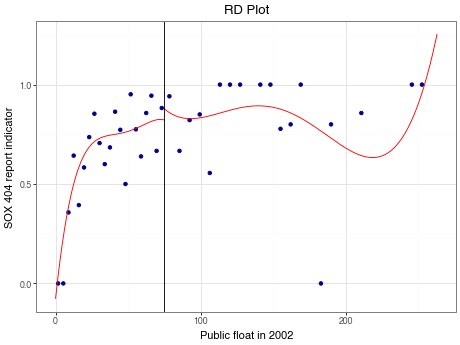


Call: rdplot
Number of Observations:                   837
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           637        200
Number of Effective Obs          637        200
Bandwith poly. fit (h)          75.0      188.0
Number of bins scale               1          1
Bins Selected                     21         27
Average Bin Length             3.571      6.963
Median Bin Length              3.571      6.963
IMSE-optimal bins               10.0        7.0
Mimicking Variance bins         21.0       27.0

Relative to IMSE-optimal:
Implied scale                    2.1      3.857
WIMSE variance weight          0.097      0.017
WIMSE bias weight              0.903      0.983


In [27]:
rdplot(reg_data_fs['sox'].astype(int), reg_data_fs['float2002'], 
       c=cutoff, masspoints="off", 
       y_label = "SOX 404 report indicator", x_label = "Public float in 2002")

**2004年公开流通股和SOX 404报告状态的RDD拟合图：**  
将结果变量更换为2004年公开流通股后，围绕75阈值的处理概率表现出明显的不连续。

/Users/lhx/opt/anaconda3/lib/python3.9/site-packages/rdrobust/rdplot.py:743: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


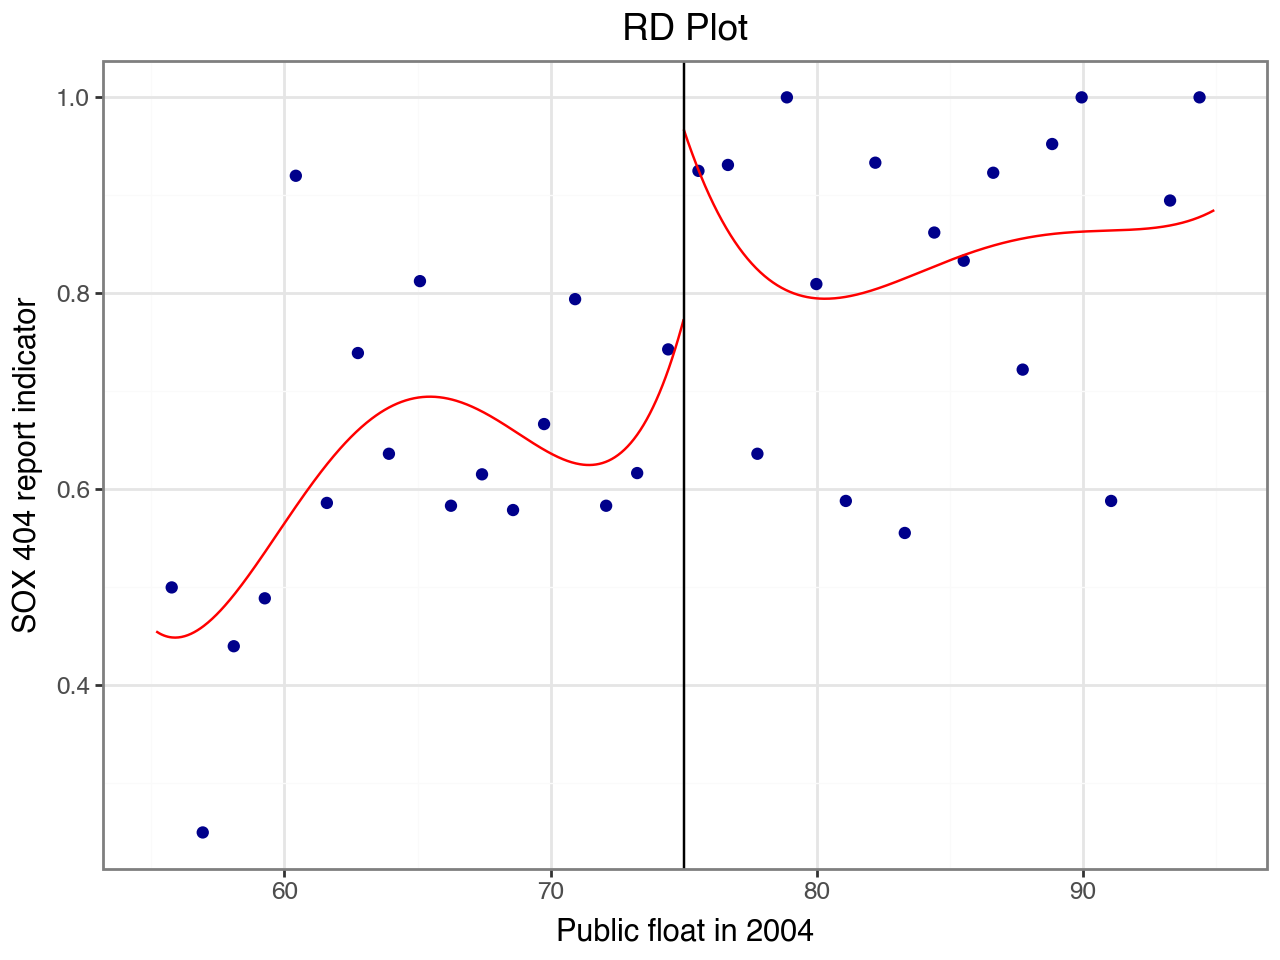


Call: rdplot
Number of Observations:                   866
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           479        387
Number of Effective Obs          479        387
Bandwith poly. fit (h)        19.821     19.936
Number of bins scale               1          1
Bins Selected                     17         18
Average Bin Length             1.166      1.108
Median Bin Length              1.166      1.108
IMSE-optimal bins                6.0        6.0
Mimicking Variance bins         17.0       18.0

Relative to IMSE-optimal:
Implied scale                  2.833        3.0
WIMSE variance weight          0.042      0.036
WIMSE bias weight              0.958      0.964


In [28]:
rdplot(reg_data_fs['sox'].astype(int), reg_data_fs['float2004'], 
       c=cutoff, masspoints="off",
       y_label = "SOX 404 report indicator", x_label = "Public float in 2004")

**2004年公开流通股和SOX 404报告状态的RDD分析：**  
进一步检验上图中float2004与sox的RDD回归结果的统计显著性，从而判断float2004是否可以作为sox的有效工具变量。  
检验结果表明，75临界值附近的处理概率跳跃为0.241，标准误为0.065，在1%水平下显著，因此float2004是sox的有效工具变量，可以使用float2004作为参考变量来对风险不对称性进行模糊RDD分析。

In [29]:
rd_fs = rdrobust(reg_data_fs['sox'].astype(int), reg_data_fs['float2004'], c=cutoff, masspoints="off")
rd_fs

Call: rdrobust
Number of Observations:                   866
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           479        387
Number of Unique Obs.            479        387
Number of Effective Obs.         193        154
Bandwidth Estimation           6.988      6.988
Bandwidth Bias                10.036     10.036
rho (h/b)                      0.696      0.696

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.241    0.065    3.706   2.110e-04     [0.113, 0.368]
Robust                 -        -    3.273   1.063e-03         [0.1, 0.4]


**2004年公开流通股和风险不对称性的模糊RDD分析（模糊处理变量为SOX 404报告状态，sox）：**  
75临界点处估计的处理效应为-0.778，标准误为0.677，在统计上与零无差异。

In [30]:
rd_ss = rdrobust(reg_data_fs['risk_asymm'], reg_data_fs['float2004'], 
                 fuzzy=reg_data_fs['sox'], c=cutoff, masspoints="off")
rd_ss

Call: rdrobust
Number of Observations:                   866
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           479        387
Number of Unique Obs.            479        387
Number of Effective Obs.         211        169
Bandwidth Estimation           7.837      7.837
Bandwidth Bias                11.938     11.938
rho (h/b)                      0.656      0.656

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.778    0.677   -1.148   2.508e-01     [-2.105, 0.55]
Robust                 -        -    -0.85   3.955e-01    [-2.212, 0.874]


**2004年公开流通股和风险不对称性的精确RDD分析：**  
75临界点处估计的处理效应为-0.211，标准误为0.177，在统计上与零无差异。

In [31]:
rd_rf = rdrobust(reg_data_fs['risk_asymm'], reg_data_fs['float2004'], c=cutoff, masspoints="off")
rd_rf

Call: rdrobust
Number of Observations:                   866
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           479        387
Number of Unique Obs.            479        387
Number of Effective Obs.         174        142
Bandwidth Estimation           5.909      5.909
Bandwidth Bias                  8.49       8.49
rho (h/b)                      0.696      0.696

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.211    0.177   -1.194   2.326e-01    [-0.558, 0.136]
Robust                 -        -   -1.018   3.089e-01    [-0.615, 0.195]


**2004年公开流通股和风险不对称性的精确RDD拟合图：**  

/Users/lhx/opt/anaconda3/lib/python3.9/site-packages/rdrobust/rdplot.py:743: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


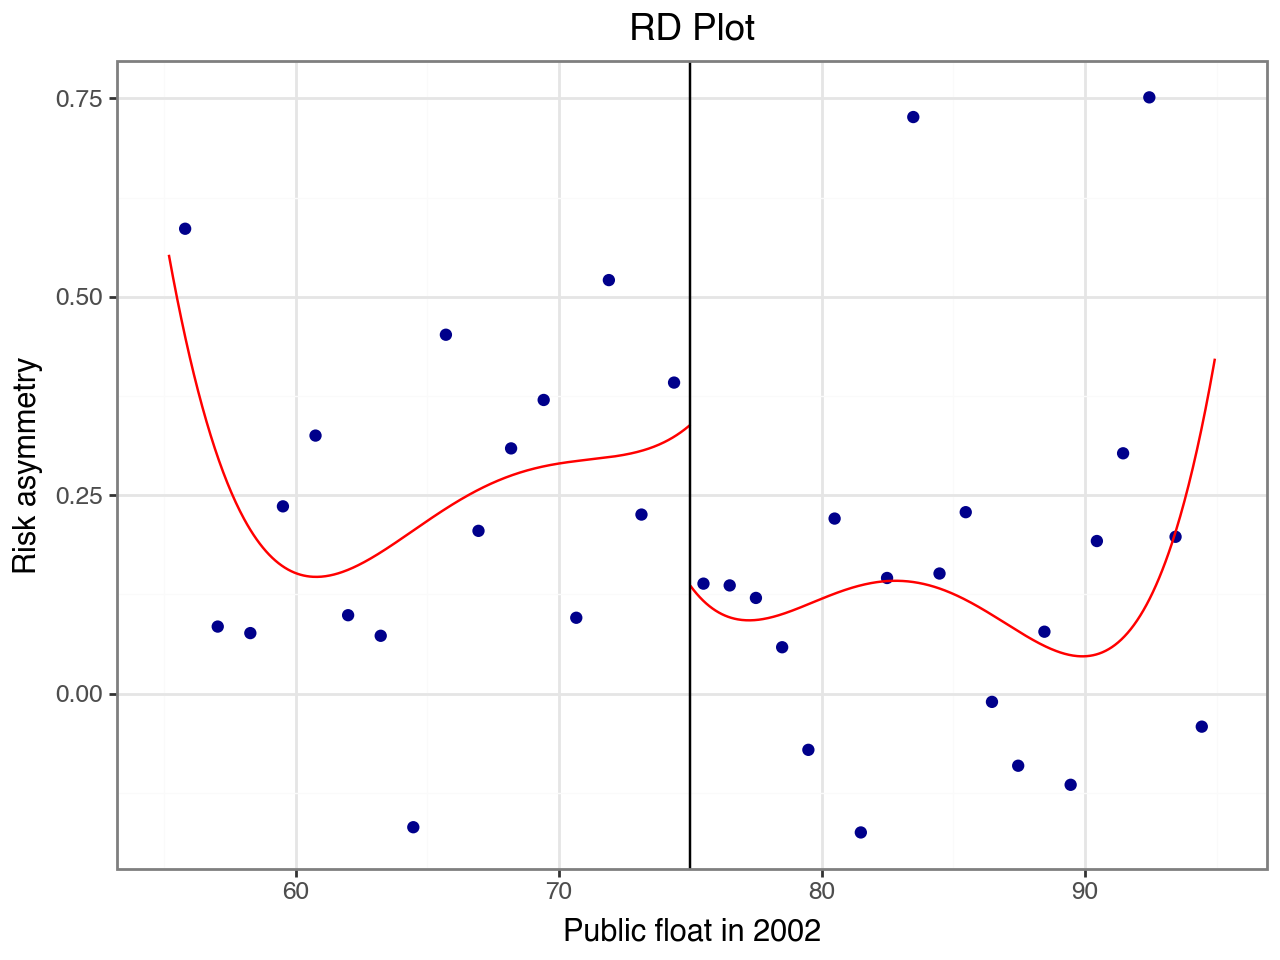


Call: rdplot
Number of Observations:                   866
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations           479        387
Number of Effective Obs          479        387
Bandwith poly. fit (h)        19.821     19.936
Number of bins scale               1          1
Bins Selected                     16         20
Average Bin Length             1.239      0.997
Median Bin Length              1.239      0.997
IMSE-optimal bins                5.0        5.0
Mimicking Variance bins         16.0       20.0

Relative to IMSE-optimal:
Implied scale                    3.2        4.0
WIMSE variance weight           0.03      0.015
WIMSE bias weight               0.97      0.985


In [32]:
rdplot(reg_data_fs['risk_asymm'], reg_data_fs['float2004'], 
       c=cutoff, masspoints="off",
       y_label = "Risk asymmetry", x_label = "Public float in 2002")

上述结果表明，在模糊RDD和精确RDD分析中，都没有拒绝SOX对风险不对称性无效应的零假设。

## 22.5 Discussion questions

### 1.Compare the data in iliev_2010 and float_data (as used in Bloomfield (2021)) for the two firms shown in the output below. What choices has Bloomfield (2021) made in processing the data for these two firms? Do these choices seem to be the best ones? If not, what alternative approach could be used?

Bloomfield(2021)使用的float_data处理方式：  
（1）只保留公司同一财报中public float最小的一条数据  
（2）同一公司不同财报报告的public float按年份分组取平均，得到公司的年度public float  
（3）保留2002、2004年的年度public float数据  

> float_data = iliev_2010.copy()  
float_data['min_float'] = float_data.groupby(['gvkey', 'fyear'])['publicfloat'].transform('min')  
float_data = float_data.query("publicfloat == min_float and pfyear.isin([2004, 2002])").reset_index(drop=True)  
float_data['float'] = float_data.groupby(['gvkey', 'pfyear'])['publicfloat'].transform('mean')  

In [33]:
iliev_2010.query("gvkey == '001728'")

,gvkey,fyear,fdate,pfdate,pfyear,publicfloat,mr,af,cik
6404,001728,2001,2001-12-31,2002-03-01,2002,96.981830,False,False,225051
6405,001728,2002,2002-12-31,2002-06-28,2002,69.074991,False,False,225051
6406,001728,2003,2003-12-31,2003-06-27,2003,71.202402,False,False,225051
6407,001728,2005,2005-01-01,2004-07-03,2004,105.826661,True,True,225051
6408,001728,2005,2005-12-31,2005-07-01,2005,87.145568,True,True,225051


In [34]:
float_data.query("gvkey == '001728'")  

,gvkey,float2002,float2004
23,001728,83.028411,NaN


In [35]:
iliev_2010.query("gvkey == '028712'")  

,gvkey,fyear,fdate,pfdate,pfyear,publicfloat,mr,af,cik
1,028712,2001,2001-12-31,2002-03-21,2002,21.523,False,False,908598
2,028712,2002,2002-12-31,2002-06-28,2002,11.460,False,False,908598
3,028712,2003,2003-12-31,2003-06-30,2003,13.931,False,False,908598
4,028712,2004,2004-12-31,2004-06-30,2004,68.161,False,False,908598
5,028712,2005,2005-12-31,2005-06-30,2005,26.437,False,False,908598


In [36]:
float_data.query("gvkey == '028712'")  

,gvkey,float2002,float2004
704,028712,16.4915,68.161


替代方法：  
（1）根据SOX 404的规定，在2002、2003、2004三年中任意一年的public float超过75百万美元时，需要提前发布内控报告，在只保留公司同一财报中的一条public float数据时，保留最大值更合适。  
（2）为了尽可能减少数据的损失，可以保留公司同一财报中public float的所有数据。

In [37]:
float_data = iliev_2010.copy()
float_data = float_data.query("pfyear.isin([2004, 2002])").reset_index(drop=True)
float_data['float'] = float_data.groupby(['gvkey', 'pfyear'])['publicfloat'].transform('mean')
float_data = (float_data
              .drop_duplicates(subset=['gvkey', 'pfyear'])
              .pivot(index='gvkey', columns='pfyear', values='float'))
float_data.columns = ['float' + str(col) for col in float_data.columns] 
float_data.reset_index(inplace=True)
float_data.query("gvkey == '001728'")

,gvkey,float2002,float2004
23,001728,83.028411,105.826661


### 2.The code treat = coalesce(float2002 >= cutoff, TRUE) above is intended to replicate Stata code used by Bloomfield (2021): generate treat = float2002 >= 75. Why does the R code appear to be more complex? What does Stata do that R does not do? 
>Stata: generate treat = float2002 >= 75  
R: treat = coalesce(float2002 >= cutoff, TRUE)  

+ Stata: generate treat = float2002 >= 75创建了一个逻辑向量，表示每个公司的流通股是否超过75，float2002缺失值比较结果仍为缺失值。   
+ R: float2002 >= cutoff创建了一个逻辑向量，表示每个公司的流通股是否超过了cutoff，其中float2002数据缺失处的比较结果被填充为NA。  
    coalesce(float2002 >= cutoff, TRUE)将由于float2002数据缺失而产生的NA值替换为TRUE。表示如果公开流通股数据缺失，公司将被视为处理组。  

### 3.Bloomfield (2021)’s Stata code for the post indicator reads generate post = fyear - (fyr > 5 & fyr <  11) >= 2005, where fyear is fiscal year from Compustat and fyr represents the month of the fiscal-year end (e.g., May would be 5). The code above sets post = datadate >= "2005-11-01". Are the two approaches equivalent? Do we seem to get the right values from post using either approach?
> Stata: generate post = fyear - (fyr > 5 & fyr <  11) >= 2005  
R: post = datadate >= "2005-11-01"

+ Stata代码的处理方式为将6-10月发布的财报向前移动一年，再将年份与2005比较。结果是2004年及之前的财报post=False，2006年及之后的财报post=True，而2005年1-5，11-12月post=True，6-10月post=False。  
+ R代码的结果是2005年10月31日及以前post=False，2005年11月1日及以后post=True。

### 4.Bloomfield (2021), inspired by Iliev (2010), uses float2002 rather than float2004 as the running variable for treatment. What issues would you be concerned about with float2004 that might be addressed using float2002? Provide some evidence to test your concerns. (Hint: Iliev (2010) uses plots, McCrary (2008) suggests some tests.) What implications do you see for the fuzzy RDD analysis we ran above using float2004 as the running variable?

使用float2004而不是float2002作为参考变量可能出现的问题：  
公司可能在知晓SOX法案中的规定后，通过操纵其公开流通股价值来避免成为提前报告者。这种操纵行为可能导致float2004数据不再是随机分配的，而是受到公司行为影响的结果，违背了使用RDD需要满足的“断点附近的公司被随机分配到处理组和对照组”的假设。  

选取75附近（55-95）的公开流通股价值数据，绘制2002年和2004年公开流通股价值的分布图：  
图形显示，2004年公开流通股价值分布相较于2002年而言，在75临界值左侧且靠近75的分布比例明显增加。2002年公开流通股价值分布在[73,77]区间的公司中有45.5%在75以下，而2004年有57.9%在75以下。

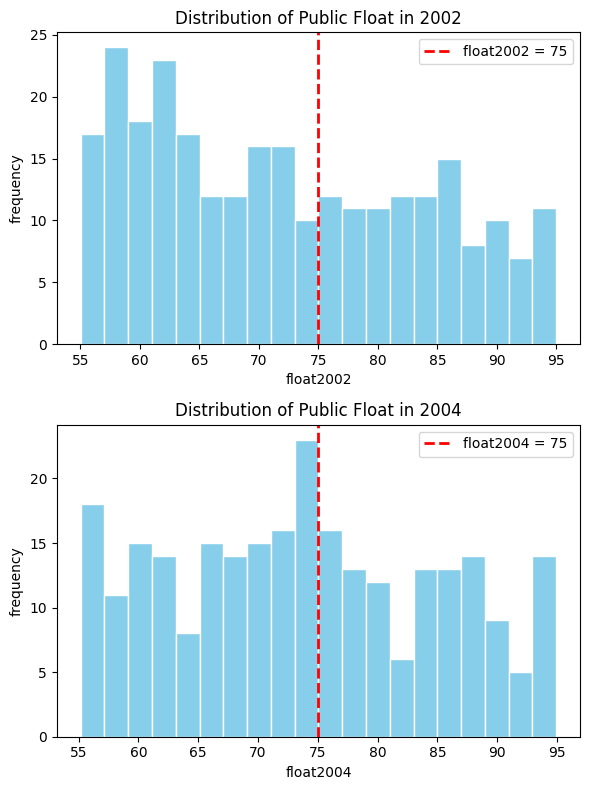

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

# 左图：2002年公开流通股价值分布
axes[0].hist(float_data.query("55 <= float2002 <= 95")['float2002'], bins=20, color='skyblue', edgecolor='white')
axes[0].axvline(x=75, color='red', linestyle='--', linewidth=2, label='float2002 = 75')
axes[0].set_title('Distribution of Public Float in 2002')
axes[0].set_xlabel('float2002')
axes[0].set_ylabel('frequency')
axes[0].legend()

# 右图：2004年公开流通股价值分布
axes[1].hist(float_data.query("55 <= float2004 <= 95")['float2004'], bins=20, color='skyblue', edgecolor='white')
axes[1].axvline(x=75, color='red', linestyle='--', linewidth=2, label='float2004 = 75')
axes[1].set_title('Distribution of Public Float in 2004')
axes[1].set_xlabel('float2004')
axes[1].set_ylabel('frequency')
axes[1].legend()

plt.tight_layout()
plt.show()


In [39]:
len(float_data.query("73 <= float2002 < 75")) / len(float_data.query("73 <= float2002 <= 77"))

0.45454545454545453

In [40]:
len(float_data.query("73 <= float2004 < 75")) / len(float_data.query("73 <= float2004 <= 77"))

0.5789473684210527